In [10]:
#dataframes
import pandas as pd
import h5py

import sys
sys.path.append('../')
import odor_statistics_lib as osm

# user defined functions

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
import scipy 
import scipy.stats as st
from scipy.stats import kurtosis
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform

#plots
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib
from figurefirst import FigureLayout,mpl_functions
import figurefirst
import matplotlib.image as mpimg
import matplotlib.colors as mcolors

from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
import figurefirst as fifi
from IPython.display import display,SVG

sns.set()
sns.set_style("whitegrid")


#misc
import cairosvg
import time
np.set_printoptions(suppress=True)
import fly_plot_lib.plot as fpl
FS=7

In [11]:
dir = '~/DataAnalysis/data/Sprints/HighRes/'
dataframe=pd.read_hdf(dir+'All_Datasets_Predictions.h5')

In [12]:
dir1='~/DataAnalysis/data/Sprints/HighRes/R2_AIC/'
df = pd.read_hdf(dir1+'all_Rsquared.h5')

In [13]:
X=[dataframe.mc_min,dataframe.mc_max, dataframe.mc_mean, dataframe.mc_std_dev, dataframe.mc_k,
     dataframe.wf_min, dataframe.wf_max, dataframe.wf_mean, dataframe.wf_std_dev, dataframe.wf_k,
     dataframe.wd_min, dataframe.wd_max, dataframe.wd_mean, dataframe.wd_std_dev, dataframe.wd_k,
     dataframe.ma_min, dataframe.ma_max, dataframe.ma_mean, dataframe.ma_std_dev, dataframe.ma_k,
     dataframe.st_min, dataframe.st_max, dataframe.st_mean, dataframe.st_std_dev, dataframe.st_k]

REMOVE_Y_CORR = True
y=dataframe.distance


corr_mat = np.zeros([len(X), len(X)])
for i in range(len(X)):
    for j in range(len(X)):
        
        if not REMOVE_Y_CORR:
            result = scipy.stats.linregress(X[i], X[j])
        else:
            result_iy = scipy.stats.linregress(y, X[i])
            resid_i = X[i] - (y*result_iy.slope + result_iy.intercept)

            result_jy = scipy.stats.linregress(y, X[j])
            resid_j = X[j] - (y*result_jy.slope + result_jy.intercept)
            
            result = scipy.stats.linregress(resid_i, resid_j)
            
        corr_mat[i,j] = result.rvalue**2
        
        

cn=['$min(WC)$','$max(WC)$','$\mu(WC)$','$\sigma(WC)$','$WC_k$',
             '$min(WF)$','$max(WF)$','$\mu(WF)$','$\sigma(WF)$','$WF_k$',
             '$min(WD)$','$max(WD)$','$\mu(WD)$','$\sigma(WD)$','$WD_k$',
             '$min(WMA)$','$max(WMA)$','$\mu(WMA)$','$\sigma(WMA)$','$WMA_k$',
             '$min(WSD)$','$max(WSD)$','$\mu(WSD)$','$\sigma(WSD)$','$WSD_k$']

In [14]:
# Convert the ndarray to a DataFrame
corr_mat_df = pd.DataFrame(corr_mat)

# Perform hierarchical clustering
Z_row = hierarchy.linkage(corr_mat_df, method='ward')
Z_col = hierarchy.linkage(corr_mat_df.T, method='ward')

# Get the order of rows and columns based on hierarchical clustering
row_order = hierarchy.leaves_list(Z_row)
col_order = hierarchy.leaves_list(Z_col)

# Reorder the data based on clustering
ordered_data = corr_mat_df.iloc[row_order, col_order]
ordered_data.index

new_names_ = [cn[i] for i in ordered_data.index]


In [15]:
newdf = df[[df.columns[i] for i in ordered_data.index]]

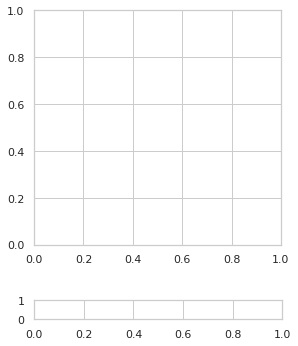

In [16]:
layout = fifi.svg_to_axes.FigureLayout('../../../Figure/clustering.svg',
                                           autogenlayers=True, make_mplfigures=True, hide_layers=[])

### Matrix

In [17]:

# Create a Matplotlib figure
ax=layout.axes[('fig','ax')]
# f, ax = plt.subplots(figsize=(9, 8))
ax.grid(False)

cax = ax.imshow(ordered_data, cmap='bone_r', aspect='auto', rasterized=True)
ax.set_rasterization_zorder(-20)

ax.set_xticks(np.arange(len(col_order)))
ax.set_yticks(np.arange(len(row_order)))


marker = np.arange(0,25,1)
mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':4},
                            smart_bounds=True,
                            yticks=marker.tolist(),
                            xticks=marker.tolist(),
                            linewidth=0.5)


alph=0.3

xlabels=ax.get_xticklabels()
ylabels=ax.get_yticklabels()

indices = [8, 9, 11, 23]

for i in indices:
    new_names_[i] = r'$\rightarrow$' + new_names_[i]

ax.set_xticklabels(new_names_, rotation=90)
ax.set_yticklabels(new_names_)


values=newdf.max(axis=0).values

full_cmap = plt.cm.get_cmap('seismic')

a1=0.4
b1=0
# Extract the blue part of the colormap
blue_part_cmap = mcolors.LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=a1, b=b1),
    full_cmap(np.linspace(a1, b1, 256))
)


# Normalize the values to the desired range
normalized_values = (values - values.min()) / (values.max() - values.min())

# Get the colors for each value
colors = blue_part_cmap(normalized_values)

# Set x and y tick label colors
for i, color in enumerate(colors):
    xlabels[i].set_color(color)
    ylabels[i].set_color(color)


figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig'], 'fig', cleartarget=True)
layout.write_svg('../../../Figure/clustering.svg')


### Colorbar

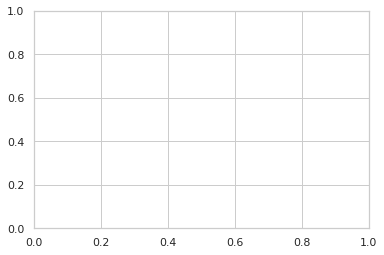

In [18]:
ax = layout.axes[('fig', 'cbar')]
xtic=[normalized_values.min(),normalized_values.max()]


norm = mcolors.Normalize(vmin=0, vmax=0.6)
ax.grid(False)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=blue_part_cmap), cax=ax,orientation='horizontal');
# fpl.colorbar(ax=ax, colormap=blue_part_cmap, orientation='horizontal',ticks=xtic)
ax.set_rasterization_zorder(-20)
mpl_functions.adjust_spines(ax, ['bottom'], 
                                    smart_bounds=True,
                                    spine_locations={'bottom': 5}, 
                                    xticks=[0,0.6],
                                    tick_length=1.5,
                                    linewidth=0.5)

ax.set_xlabel("$R^2$",rotation=0, labelpad=-5)

ax.set_xticklabels(['0', '0.6'])
figurefirst.mpl_functions.set_fontsize(ax, FS)

layout.append_figure_to_layer(layout.figures['fig'], 'fig', cleartarget=True)
layout.write_svg('../../../Figure/clustering.svg')